In [28]:
from datetime import datetime, timedelta
import yfinance as yf  
import pandas as pd  
import numpy as np 
from scipy.optimize import minimize


In [25]:
tickers = ['SPY','BND','GLD','QQQ','VTI']
end_date = "2023-01-01"
start_date = "2018-01-01" 
adj_close_df = pd.DataFrame()

In [26]:
for ticker in tickers:
    data = yf.download(ticker, period="{}d".format((datetime.strptime(end_date, "%Y-%m-%d") - datetime.strptime(start_date, "%Y-%m-%d")).days))
    adj_close_df[ticker] = data['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [30]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))

In [31]:
log_returns = log_returns.dropna()

In [32]:
cov_matrix = log_returns.cov() * 252

In [33]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [34]:
risk_free_rate = .02

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.4) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [35]:
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
SPY: 0.2118
BND: 0.0000
GLD: 0.3882
QQQ: 0.4000
VTI: 0.0000
Expected Annual Return: 0.1165
Expected Volatility: 0.1448
Sharpe Ratio: 0.6661


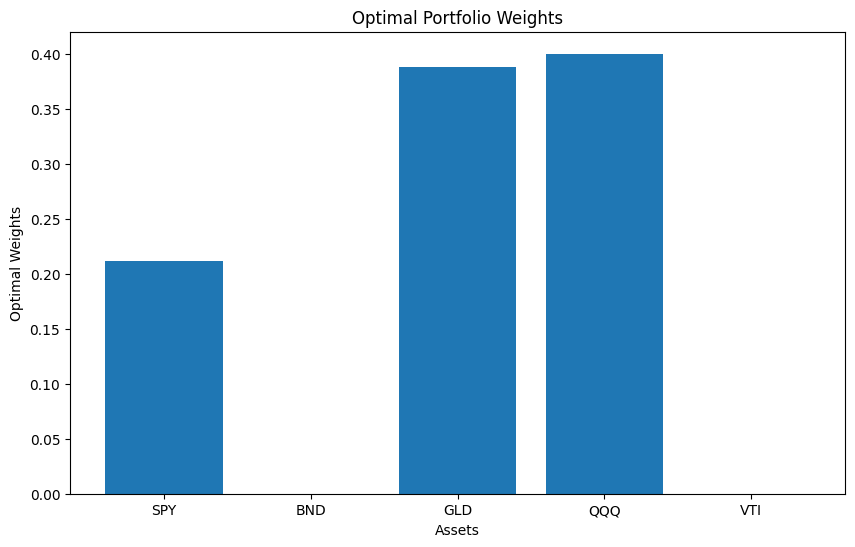

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()